## How Neural Network sees a Cat

이미지넷에서 사전 훈련된 신경망은 다양한 품종의 고양이와 같은 1000가지 종류의 물체를 인식할 수 있음 인공 신경망에서 **이상적인 샴 고양이**는 어떻게 생겼는지 보기로 함

먼저 VGG 네트워크를 로드 합니다

In [1]:
# mac에서 실행시킬 경우 문제를 해결하기 위해 ssl 관련 코드임.

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# SSL 인증서 검증을 우회하는 설정으로 시작
# Python의 ssl 모듈을 사용하여 HTTPS 연결 시 기본적으로 사용되는 SSL 컨텍스트를 검증하지 않는 컨텍스트로 변경하면 SSL 인증서 관련 오류 없이 외부 리소스(예: tensorflow 패키지)를 안전하지 않게 다운로드할 수 있음

%pip install tensorflow
%pip install matplotlib

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from PIL import Image
import json
np.set_printoptions(precision=3,suppress=True) #precision 과정을 다루는 과정
# tensorflow 라이브러리를 설치하고 필요한 모듈들을 임포트
# tensorflow의 keras 모듈, matplotlib.pyplot, numpy, IPython.display, PIL 및 json 모듈을 사용
# numpy의 출력 옵션을 설정하여 소수점 아래 셋째 자리까지 표시하고 과학적 표기법을 사용하지 않도록 함

model = keras.applications.VGG16(weights='imagenet',include_top=True)
classes = json.loads(open('imagenet_classes.json','r').read())
# keras의 VGG16 모델을 imagenet 데이터셋의 가중치와 함께 최상위 레이어를 포함하여 로드
# 이 모델은 이미지 분류 작업에 널리 사용하는데 imagenet_classes.json 파일을 읽어 이미지넷 데이터셋의 클래스 정보를 로드
# 이 코드는 기본적으로 신경망 모델을 설정하고 사용할 준비를 하는 과정

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2024-05-08 07:55:14.893248: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 07:55:14.932564: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 07:55:15.039053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 07:55:22.370551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-08 07:55:27.751254: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-05-08 07:55:28.595763: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of 

## Optimizing for Result

이상적인 고양이를 시각화하기 위해 무작위 노이즈 이미지로 시작하여 그라데이션 하강 최적화 기법을 사용하여 네트워크가 고양이를 인식할 수 있도록 이미지를 조정

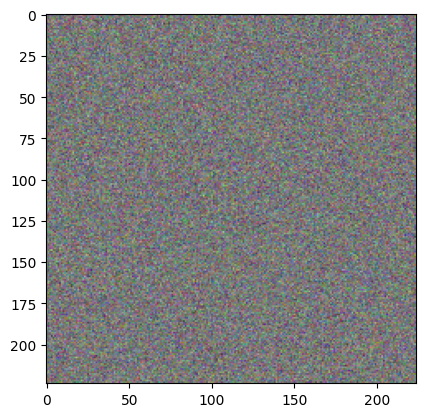

In [2]:
# TensorFlow를 사용하여 이미지 데이터를 정규화하고 시각화하는 과정

# 변수 생성
x = tf.Variable(tf.random.normal((1,224,224,3))) #224, 224, 채널 : 3(RGB)
# 평균이 0이고 표준편차가 1인 정규 분포에서 랜덤한 값을 가진 4차원 텐서를 생성
# 텐서는 일반적으로 이미지 데이터를 표현하며, 크기는 (1, 224, 224, 3)인데 여기서 1은 배치 크기, 224 x 224는 이미지의 크기, 3은 RGB 채널을 나타냅니다.

# 정규화 함수 (데이터를 표준정규 분포를 따라서 95% 중앙 분포의 값들을 기준으로 빼서 정규화를 진행하여 필요없는 값들을 정리한 후 데이터를 정돈된 상태로 만들어 시작한다. 이런 작업을 하는 이유는 극단적인 값을 통해서 overfitting의 결과를 초래할 가능성이 있기 때문에 이를 사전에 예방기 위해서 데이터를 정규화 시키는 과정을 진행한다.)
def normalize(img):
    return (img-tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img))
# 함수는 입력된 이미지 데이터를 0과 1 사이의 값으로 정규화하는데 입력 이미지에서 최소값을 빼고, 그 결과를 최대값과 최소값의 차이로 나누어 계산
# 이 방식은 이미지 데이터의 스케일을 조정하여 모델 학습에 적합하게 만들어 줌

# 이미지 시각화
plt.imshow(normalize(x[0]))
# 정규화된 이미지 데이터를 시각화하는데 x[0]은 배치의 첫 번째 이미지를 나타내며, matplotlib.pyplot의 imshow 함수를 사용하여 이미지를 표시  
           

If we call our VGG network on this image, we will get more or less random distribution of probabilities:

상단의 이미지 데이터를 vgg-16에 넣어보자

Predicted class: 669 (mosquito net)
Probability of predicted class = 0.05754246190190315


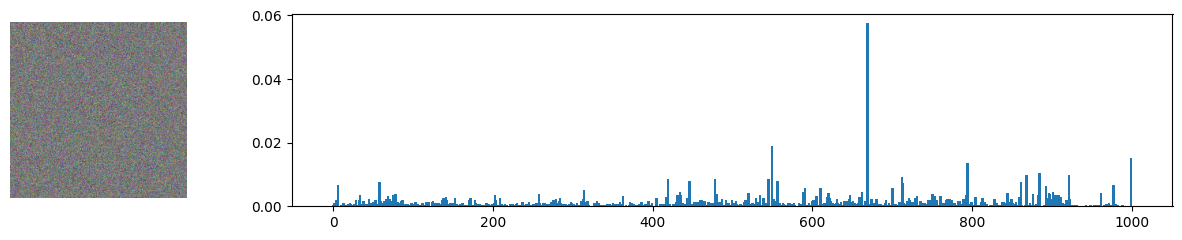

In [3]:
def plot_result(x):
    res = model(x)[0]
    cls = tf.argmax(res)
    cls_idx = int(cls)  # 텐서를 정수로 변환
    print(f"Predicted class: {cls_idx} ({classes[cls_idx]})")  # 정수 인덱스 사용
    print(f"Probability of predicted class = {res[cls]}")
    fig, ax = plt.subplots(1, 2, figsize=(15, 2.5), gridspec_kw={"width_ratios": [1, 5]})
    ax[0].imshow(normalize(x[0]))
    ax[0].axis('off')
    ax[1].bar(range(1000), res, width=3)
    plt.show()

plot_result(x)

# 상단 이미지(mosquito net)에 대한 분석

===============================================

확률 : 0.05754246190190315로 나옴

1000개를 기준으로 57번은 맞는 경우를 의미하는 수치값으로서, 수치값이 좋지 않은 것을 확인 가능하다.

===============================================

> 한 클래스의 확률이 다른 클래스보다 훨씬 높은 것처럼 보일 수 있지만, 실제 확률은 여전히 5% 내외라는 것을 눈금을 보면 알 수 있음

하나의 카테고리(예: **고양이**)를 선택하고 그라데이션 하강을 사용하여 이미지를 조정

If $x$ is the input image, and $V$ is the VGG network, we will calculate the loss function $\mathcal{L} = \mathcal{L}(c,V(x))$ (where $c$ is the target category), and adjust $x$ using the following formula:
$$
x^{(i+1)} = x^{(i)} - \eta{\partial \mathcal{L}\over\partial x}
$$
손실 함수는 두 개의 확률 분포를 비교하기 때문에 교차 엔트트피 손실이 되는데 이 경우 클래스가 원핫 인코딩된 벡터가 아닌 숫자로 표현되므로 *스파스 범주형 교차 엔트로피*를 사용합니다.

이 과정을 여러 번에 걸쳐 반복하면서 이미지를 프린트

> It is better to execute this code on GPU-enabled compute, or reduce the number of epochs in order to minimize waiting time.

입력을 바꾸어서 이미지를 쑤셔 넣어서 고양이가 나오도록 목표를 설정하는 방법으로 진행된다.


Epoch: 600, loss: 1.1114953756332397


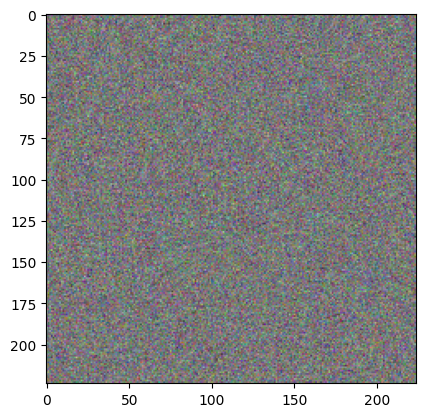

KeyboardInterrupt: 

In [4]:
target = [284] # Siamese 고양이에 해당하는 클래스 인덱스를 목표로 설정

# 실제값과 예측값 사이의 크로스 엔트로피 손실을 계산하는 함수
def cross_entropy_loss(target,res):
    return tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))

# 모델을 최적화하는 함수로, 입력 이미지 x와 목표 클래스 target, 그리고 에포크 수 등을 매개변수로 받음
# 에포크마다 모델의 결과 res와 손실 loss를 계산하고, 계산된 그래디언트를 이용해 입력 이미지 x를 업데이트
def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss, eta=1.0): #epochs를 1000번 돌림, 매번 보여주는 옵션 : None, loss_fn 방법은 cross_entropy_loss 방법 활용
    if show_every is None:
        show_every = epochs // 10 #epoch 100번에 한번씩 출력을 진행함.
    for i in range(epochs):
        with tf.GradientTape() as t: # TensorFlow의 자동 미분 기능을 활용해 그래디언트를 계산
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            x.assign_sub(eta*grads) # 계산된 그래디언트에 학습률 eta를 곱한 값으로 x를 업데이트
            if i%show_every == 0:
                clear_output(wait=True) # 출력을 지우고 진행 과정을 시각적으로 보여주기 위해 사용되는 함수
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0])) # 최신화된 이미지를 표시하고 진행 과정을 시각적으로 보여주기 위해 사용되는 함수
                plt.show()

# optimize 함수는 이미지 x를 목표 클래스 target에 더 가깝게 만드는 방향으로 점차 업데이트하여 모델을 최적화
optimize(x,target)

상단 코드의 실습의 경우 colab을 통해 실습을 진행한 코드가 있으니 참고할 것

결론은 학습에 따라 기존의 에측의 결과값에 비해서 월등히 높은 정확도를 가져갈 것이라고 예상함.

10000번의 학습을 colab으로 진행한 경우 기존의 정확도가 0.058xxxx로 존재하였으나, 10000번 학습 이후에는 0.987xxxx로 월등한 수치로 값이 상승했음을 확인기 가능하다는 것을 알 수 있다.


Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.6479002237319946


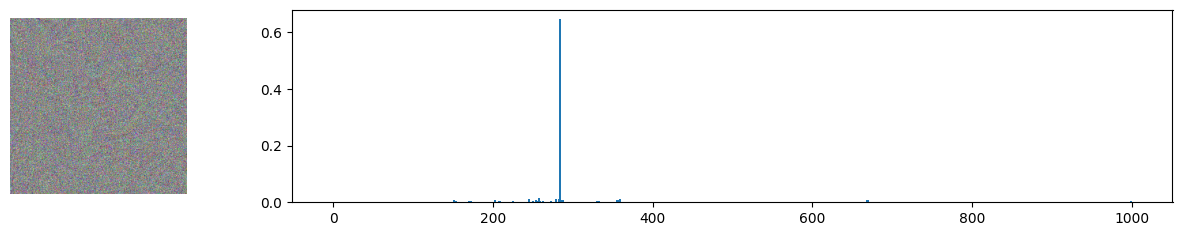

In [8]:
plot_result(x)

We now have obtained an image that looks like a cat for a neural network, even though it still looks like a noise for us. If we optimize for a little bit longer - we are likeley to get the image of **ideal noisy cat**, which has probability close to 1.

## Making Sense of Noise

이 노이즈는  큰 의미가 없지만 아마도 고양이에게 일반적인 저수준 필터가 많이 포함되어 있을 수  있음
그러나 이상적인 결과를 위해 입력을 최적화하는 방법은 매우 다양하기 때문에 최적화 알고리즘은 시각적으로 이해할 수 있는 패턴을 찾는것을 우선하지 않음

그림을 조금 덜 노이즈처럼 보이게 하기 위해 손실 함수에 **변이 손실**을추가 할 수 있는데  이 함수는 이미지의 인접 픽셀이 얼마나 유사한지를 측정
이 함수를 *손실 함수*에 추가하면 옵티마이저가 노이즈가 적은 솔루션을 찾게 되고, 따라서 더 많은 디테일을 인식할 수 있음

좋은 결과를 얻으려면 교차 엔트로피 손실과 변동 손실 사이의 균형을 맞춰야 함

Epoch: 300, loss: [27.959]


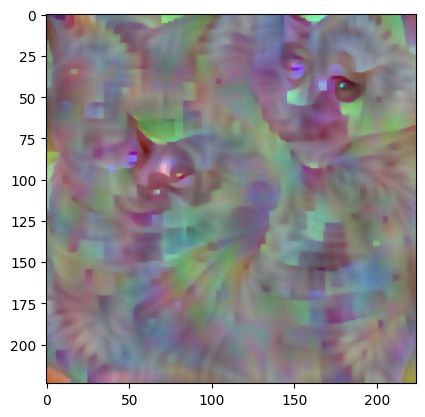

KeyboardInterrupt: 

In [5]:
# total_loss 함수를 정의하고, 이를 사용하여 이미지 x를 최적화하는 optimize 함수를 호출
# 이 함수는 두 부분으로 구성된 손실 함수를 사용
# Sparse Categorical Crossentropy: 이는 실제 클래스 target과 예측 결과 res 사이의 손실을 계산
# 손실에 더 큰 비중을 두도록 함
# Total Variation: 입력 이미지 x와 결과 res의 총 변동을 계산
# 총 변동은 이미지의 픽셀 간 변화를 측정하며, 이는 이미지의 부드러움을 유지하는데 도움이 됨
# 이 값은 0.005로 스케일되어 전체 손실에 작은 영향을 줌
def total_loss(target,res):
    return 10*tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res)) + \
           0.005*tf.image.total_variation(x,res)

# loss_fn 매개변수에 total_loss 함수를 지정하여, 기존의 크로스 엔트로피 손실 외에 이미지의 부드러움을 유지하는 것을 목표로 최적화 프로세스를 진행
# 이 방법은 이미지가 목표 클래스에 속하면서도 시각적으로 자연스러운 변화를 유지하도록 함
optimize(x,target,loss_fn=total_loss)

This is the ideal image of a cat for our neural network, and we can also see some of the familiar features, such as eyes and ears. There are many of them, which makes neural network even more certain that this is a cat.

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.9173721671104431


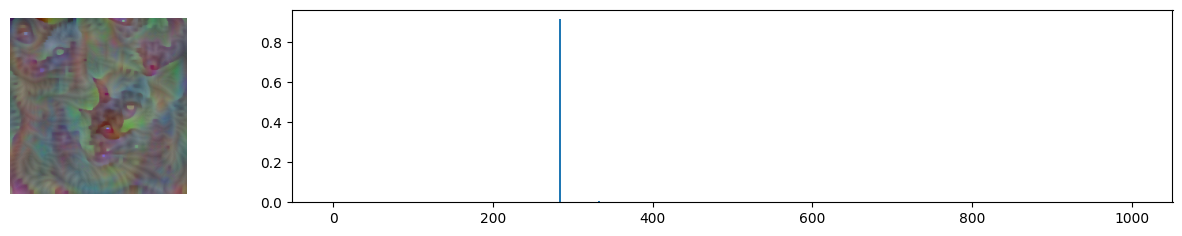

In [10]:
plot_result(x)

Let's also see how some other object looks like for the VGG:

Epoch: 900, loss: [29.342]


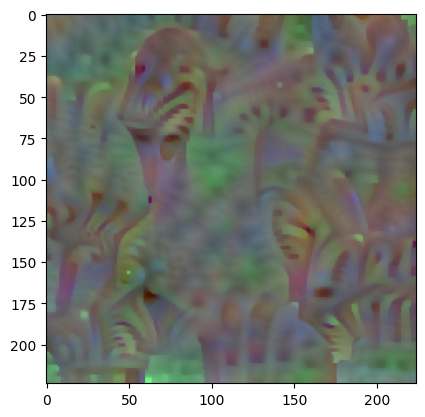

In [11]:
# 이 코드는 TensorFlow를 사용하여 특정 이미지 최적화 작업을 설정하고 실행하는 과정을 보여줌
# 여기서 목표는 "zebra"에 해당하는 클래스 (클래스 인덱스 340)의 이미지를 생성
# 이 코드는 신경망을 통해 입력 이미지를 직접 조작하여, 원하는 클래스의 특징을 갖도록 이미지를 점차적으로 변형시키는 과정을 진행

# 변수 설정: x는 TensorFlow 변수로, 크기가 (1, 224, 224, 3)인 텐서로 초기화됨
# 이는 하나의 224x224 크기의 RGB 이미지를 나타내는데 텐서는 정규 분포를 따르는 랜덤 값으로 초기화

# 손실 함수: total_loss 함수가 손실을 계산하는데 사용됨
# 함수는 실제 클래스와 예측 결과 사이의 크로스 엔트로피 손실을 주요 요소로 사용하며, 이미지의 총 변동을 추가하여 이미지의 부드러움을 유지

# 최적화 함수 호출: optimize 함수는 이미지 x, 목표 클래스 [340] (zebra), 그리고 total_loss 함수를 매개변수로 사용하여 호출
# 이 함수는 x를 업데이트하여 목표 클래스를 잘 나타내면서도 자연스러운 이미지를 생성하는 것을 목표

x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,[340],loss_fn=total_loss) # zebra

## Adversarial Attacks

기존의 입력된 강아지 이미지를 고양이 이미지를 삽입하여 학습시킨 후 고양이 처럼 보이도록 변형하는 방법으로 실습을 진행하는 방법이다.

이상적인 고양이 이미지는 임의의 노이즈처럼 보일 수 있으므로 이미지를 약간 조정하여 클래스를 변경할 수 있음
강아지 이미지부터 시작

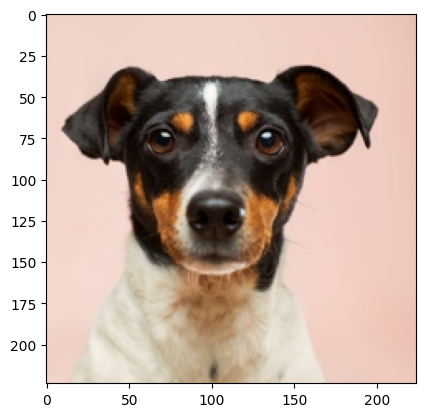

In [13]:
# PIL (Pillow) 라이브러리와 NumPy를 사용하여 이미지를 처리하는 방법을 보여줌

img = Image.open('./dog-from-unsplash.jpg')
img = img.crop((200,20,600,420)).resize((224,224))
# 이미지를 (200, 20, 600, 420) 좌표로 지정된 사각형 영역으로 자른 후, 결과 이미지를 224x224 크기로 조정
img = np.array(img)
plt.imshow(img)

We can see that this image is clearly recognized as a dog:

Predicted class: 171 (Italian greyhound)
Probability of predicted class = 0.9281901121139526


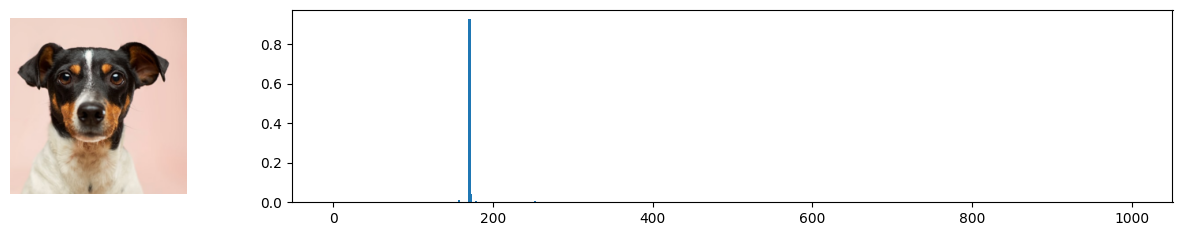

In [14]:
plot_result(np.expand_dims(img,axis=0))
# np.expand_dims(img,axis=0는 umPy의 expand_dims를 사용하여 img 배열에 새로운 축을 시작 부분에 추가
# 일반적으로 모델 입력을 위해 이미지 배열을 준비할 때 사용되며, 배열의 형태는 (높이, 너비, 채널)에서 (1, 높이, 너비, 채널)로 변경
# 이는 단일 이미지를 하나의 아이템을 가진 배치로 변환


Now, we will use this image a starting point, and try to optimize it to become a cat:

Epoch: 90, loss: 0.15771391987800598


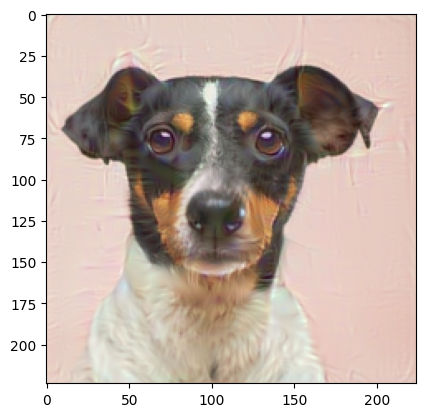

In [15]:
# 이미지 img를 처음에 차원을 확장하여 배치 형태로 만든 다음, 데이터 타입을 np.float32로 변환하고 255.0으로 나누어 정규화
# 정규화는 이미지 데이터를 처리할 때 일반적으로 사용되며, 입력 픽셀 값을 0과 1 사이로 스케일링하여 모델 학습을 용이하게 함
x = tf.Variable(np.expand_dims(img,axis=0).astype(np.float32)/255.0)

# 이미지 텐서 x, 목표 클래스 target, 그리고 에포크 수(100 에포크)를 매개변수로 받아 최적화를 수행
# 이 함수는 손실 함수(loss_fn)를 계산하고, 그래디언트를 이용하여 x를 업데이트하며, 이 과정을 주어진 에포크만큼 반복
optimize(x,target,epochs=100)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.8649703860282898


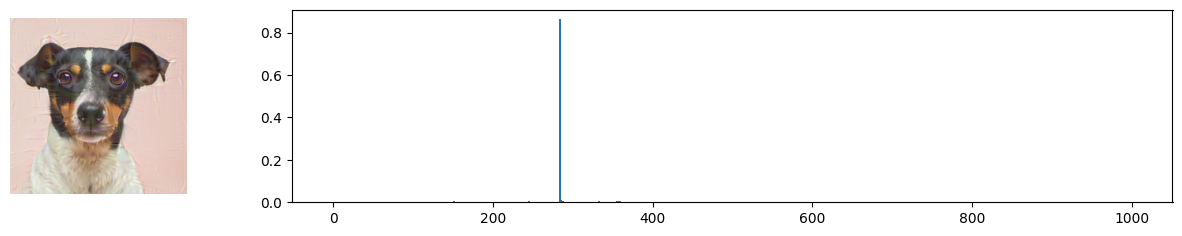

In [16]:
plot_result(x)

So, this image above is a perfect cat, from the point of view of VGG network!

## Experimenting with ResNet (keras 내부의 모듈임)

Let's now see how this same image is classified by a different model, say, ResNet:

In [17]:
model = keras.applications.ResNet50(weights='imagenet',include_top=True)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


> Since we used `model` as a global variable, from now on all functions will use ResNet instead of VGG

Predicted class: 111 (nematode, nematode worm, roundworm)
Probability of predicted class = 0.1309564709663391


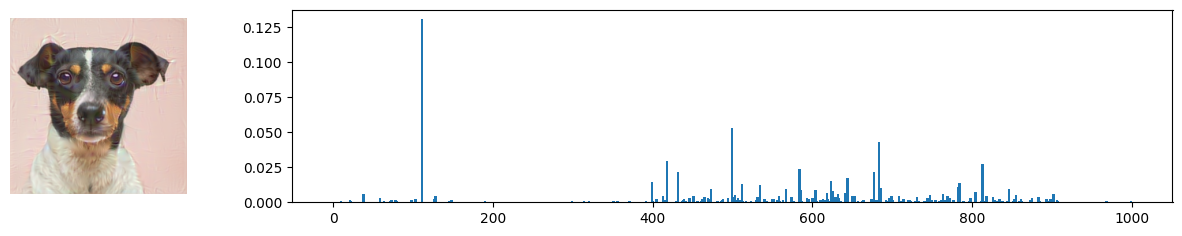

In [18]:
plot_result(x)

Apparenlty, the result is quite different. This is quite expected, because when optimizing for a cat we took into account the nature of VGG network, it's low-level filters, etc. Since ResNet has different filters, it gives different results. 

Let's see how the ideal zebra looks like for ResNet:

Epoch: 450, loss: [43.474]


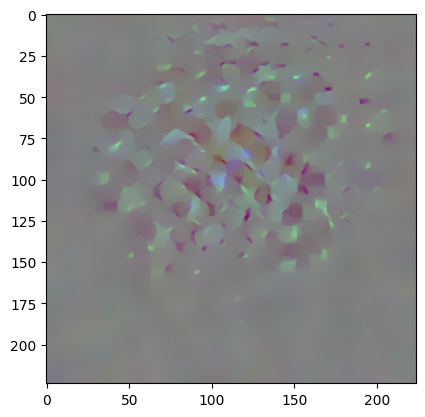

In [19]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,target=[340],epochs=500,loss_fn=total_loss)

Predicted class: 340 (zebra)
Probability of predicted class = 0.8871756792068481


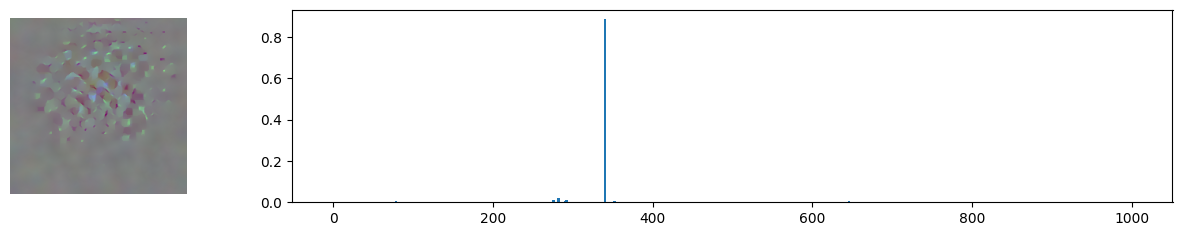

In [20]:
plot_result(x)

This picture is quite different, which tells us that the architecture of a neural network probably plays quite an important role in the way it recognizes objects.